In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

2024-11-18 18:20:53.403029: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 18:20:53.423159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731972053.442822 1798870 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731972053.448791 1798870 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 18:20:53.469753: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
base_path = os.path.expanduser('~/DL/Data/genres_original')

# List all genres and audio files
genres = os.listdir(base_path)

# Create a list to hold the file paths and their respective labels
file_paths = []
labels = []

for genre in genres:
    genre_folder = os.path.join(base_path, genre)
    if os.path.isdir(genre_folder):
        for audio_file in os.listdir(genre_folder):
            if audio_file.endswith(".wav"):  # Only consider .wav files
                file_paths.append(os.path.join(genre_folder, audio_file))
                labels.append(genre)

# Create a DataFrame
data = pd.DataFrame({
    'filename': file_paths,
    'genre': labels
})

In [3]:
# Split dataset into training and testing sets
X_train, X_test = train_test_split(data, test_size=0.2, random_state=150)

# YAMNet model from TensorFlow Hub (using pre-trained YAMNet model)
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")

W0000 00:00:1731972067.450595 1798870 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
def extract_features(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None  # Skip this file if not found

    try:
        # Load the audio file
        audio_waveform, sample_rate = tf.audio.decode_wav(tf.io.read_file(file_path), desired_channels=1)
        audio_waveform = tf.squeeze(audio_waveform, axis=-1)  # Remove the channel dimension

        # Run audio through YAMNet for feature extraction
        scores, embeddings, spectrogram = yamnet_model(audio_waveform)

        # Average the embeddings across all frames to get a fixed-size feature vector
        embedding_avg = np.mean(embeddings.numpy(), axis=0)  # Averaging across time frames

        return embedding_avg
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None  # Or handle accordingly, e.g., return a zero vector

In [5]:
# Extract features for training and test data
X_train_features = [extract_features(file) for file in X_train['filename']]
X_train_features = [x for x in X_train_features if x is not None]  # Remove None values

X_test_features = [extract_features(file) for file in X_test['filename']]
X_test_features = [x for x in X_test_features if x is not None]  # Remove None values

# Convert to numpy array
X_train_features = np.array(X_train_features)
X_test_features = np.array(X_test_features)

# Verify that the shapes are consistent
print(f"X_train_features shape: {X_train_features.shape}")
print(f"X_test_features shape: {X_test_features.shape}")

X_train_features shape: (799, 1024)
X_test_features shape: (200, 1024)


In [7]:
# Normalize the features using StandardScaler (improves convergence)
scaler = StandardScaler()
X_train_features = scaler.fit_transform(X_train_features)
X_test_features = scaler.transform(X_test_features)

# Convert genre labels to categorical format
y_train = to_categorical(X_train['genre'].astype('category').cat.codes)
y_test = to_categorical(X_test['genre'].astype('category').cat.codes)

In [11]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

new_model = Sequential([
    # Convolutional layer with 64 filters, kernel size of 3, and ReLU activation
    Conv1D(64, 3, activation='relu', input_shape=(X_train_features.shape[1], 1)),
    MaxPooling1D(2,2),  # Max pooling to reduce dimensionality
    Dropout(0.3),

    # Flatten the output of convolutional layers to feed into Dense layers
    Flatten(),
    
    Dense(256, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    
    # Final output layer for classification
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model with an initial learning rate
new_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
new_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 1022, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 511, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32704)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     8,372,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,416,330 (32.11 MB)

 Trainable params: 8,415,434 (32.10 MB)

 Non-trainable params: 896 (3.50 KB)

In [12]:
# Train the model
es = EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=10)
history = new_model.fit(X_train_features, y_train, validation_data=(X_test_features, y_test), epochs=100, batch_size=64, callbacks=[es])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3083 - loss: 2.1407 - val_accuracy: 0.4900 - val_loss: 2.6029
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5636 - loss: 1.2610 - val_accuracy: 0.6600 - val_loss: 2.0966
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6480 - loss: 1.0816 - val_accuracy: 0.7350 - val_loss: 1.7042
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6767 - loss: 0.9561 - val_accuracy: 0.7650 - val_loss: 1.4252
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7586 - loss: 0.7760 - val_accuracy: 0.7900 - val_loss: 1.2512
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7596 - loss: 0.7305 - val_accuracy: 0.8100 - val_loss: 1.1301
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7737 - loss: 0.7267 - val_accuracy: 0.8200 - val_loss: 1.1508
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8278 - loss: 0.6344 - val_accuracy: 0.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8608 - loss: 1.0893 
Test accuracy: 0.8600


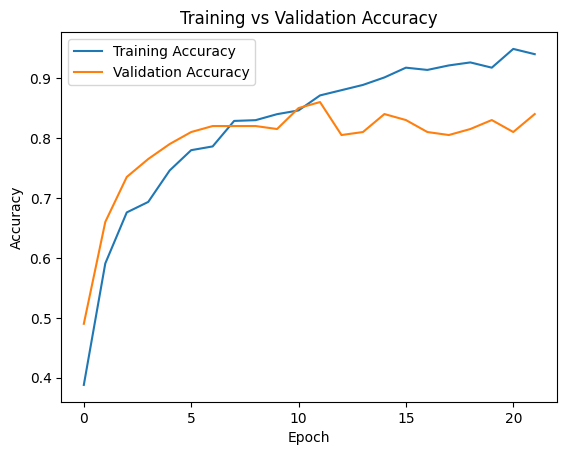

In [13]:
# Evaluate the model
loss, accuracy = new_model.evaluate(X_test_features, y_test)
print(f"Test accuracy: {accuracy:.4f}")

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


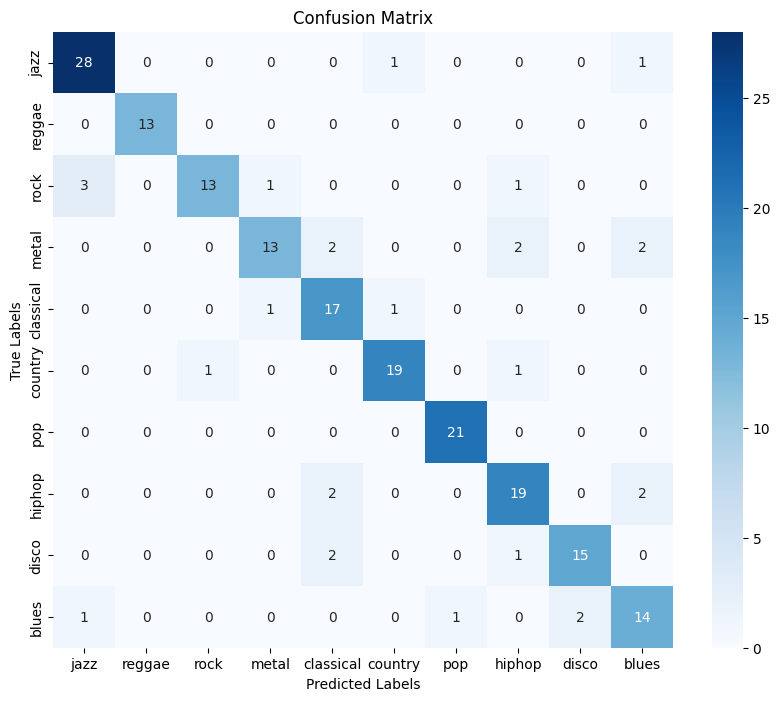

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predict the labels on the test data
y_pred = new_model.predict(X_test_features)

# Convert predictions from one-hot encoding to integer labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [15]:
new_model.save('yamnetbest.h5')